# EuroSAT_MS – Colab + Google Drive Version (Conventional ML Baseline)

This notebook is an updated solution that:
- Mounts **Google Drive** and extracts your **EuroSAT_MS .zip** directly in Colab.
- Covers the **visual tasks** (RGB view, NDVI, thresholded segmentation mask, per-band inspection).
- For the **first modeling task**, uses **conventional machine learning** (feature engineering + scikit-learn classifiers) — **not** a CNN.
- Compares simple models (Logistic Regression, SVM, RandomForest) on a validation split.


## 1) Mount Google Drive and extract the dataset


### Cell 2 – Install rasterio
Installs rasterio inside the Colab runtime so GeoTIFFs can be read via rasterio.


In [1]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 45.9 MB/s eta 0:00:00


### Cell 3 – Import project dependencies
Loads Drive helpers plus all numpy/matplotlib/sklearn utilities used across the notebook.


In [2]:
from google.colab import drive
from pathlib import Path
import os, glob, subprocess
import os, sys, random, math, json, glob
import numpy as np
import numpy as np
import rasterio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Cell 4 – Mount Google Drive
Mounts the user's Drive at `/content/drive` to access the EuroSAT and Kaggle archives.


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


### Cell 5 – Extract EuroSAT archive
Defines dataset paths and unzips `EuroSAT_MS.zip` from Drive into `/content` if needed.


In [4]:
ZIP_PATH = "/content/drive/MyDrive/ML_HSG/EuroSAT_MS.zip"
DATA_ROOT = Path("/content/EuroSAT_MS")

if not DATA_ROOT.exists():
    print("Extracting dataset from", ZIP_PATH, "to /content ...")
    !unzip -q -o "$ZIP_PATH" -d "/content"
else:
    print("Dataset already extracted at", DATA_ROOT)

print("DATA_ROOT =", DATA_ROOT)


Extracting dataset from /content/drive/MyDrive/ML_HSG/EuroSAT_MS.zip to /content ...
DATA_ROOT = /content/EuroSAT_MS


## 2) Configuration & Utilities


### Cell 7 – Set deterministic seeds
Initializes the Python and NumPy RNGs for reproducible train/val/test splits.


In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("Data root:", DATA_ROOT.resolve())


Data root: /content/EuroSAT_MS


## 3) Load GeoTIFFs and Visualize (RGB, NDVI, Bands)


### Cell 9 – Read and normalize GeoTIFFs
Provides `read_multiband_tif` that loads Sentinel-2 tiles and scales each band robustly to [0,1].


In [6]:
def read_multiband_tif(path):
    with rasterio.open(path) as src:
        arr = src.read()  # (C,H,W)
        arr = arr.astype(np.float32)
        # robust per-band normalization to [0,1]
        C,H,W = arr.shape
        for i in range(C):
            band = arr[i]
            lo, hi = np.percentile(band, [2, 98])
            if hi > lo:
                band = (band - lo) / (hi - lo)
            else:
                bmin, bmax = band.min(), band.max()
                band = (band - bmin) / (bmax - bmin + 1e-6)
            arr[i] = np.clip(band, 0.0, 1.0)
        return arr

### Cell 10 – Compute NDVI
Defines the `ndvi_from_arr` helper derived from the red (B4) and near-infrared (B8) bands.


In [7]:
def ndvi_from_arr(arr):
    nir = arr[7]  # B8
    red = arr[3]  # B4
    return (nir - red) / (nir + red + 1e-6)

### Cell 11 – Visualize a sample tile
Plots an RGB rendering and NDVI heatmap for any selected multiband tile.


In [8]:
def show_sample(path, title="Sample"):
    arr = read_multiband_tif(path)
    rgb = np.stack([arr[3], arr[2], arr[1]], axis=-1)  # B4,B3,B2
    ndvi = ndvi_from_arr(arr)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(np.clip(rgb,0,1)); plt.title(f"{title} – RGB"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(ndvi, cmap="RdYlGn"); plt.title("NDVI"); plt.axis("off")
    plt.show()

### Cell 12 – Enumerate classes and build sample list
Discovers EuroSAT class folders, maps names to indices, collects all sample paths, and previews one tile.


Detected classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Found 27000 images.


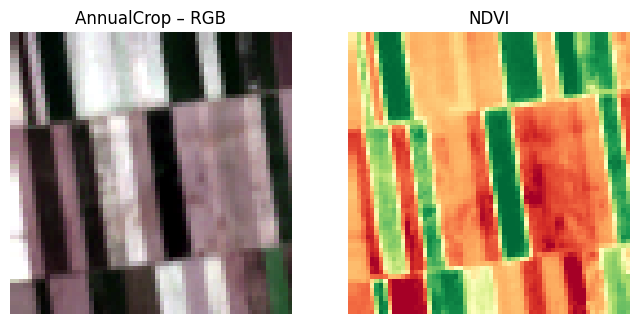

In [9]:
# Expected Sentinel-2 band order (EuroSAT-MS): indices 0..12 for 13 bands
# NDVI: NIR=B8 (idx 7), RED=B4 (idx 3)

CLASS_NAMES = []
if DATA_ROOT.exists():
    for d in sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()]):
        CLASS_NAMES.append(d.name)
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASS_NAMES)}
print("Detected classes:", CLASS_NAMES)

# Collect samples
samples = []
for cls in CLASS_NAMES:
    for tif in (DATA_ROOT/cls).glob("*.tif"):
        samples.append((tif, CLASS_TO_IDX[cls]))
print(f"Found {len(samples)} images.")

# Quick peek (1 sample)
if samples:
    show_sample(samples[0][0], title=CLASS_NAMES[samples[0][1]])


### NDVI thresholding (vegetation mask)


### Cell 14 – Threshold NDVI
Builds a binary vegetation mask with a tunable NDVI cutoff for downstream visualization.


In [10]:
def threshold_ndvi(ndvi, thr=0.3):
    return (ndvi > thr).astype(np.uint8)

### Cell 15 – Plot NDVI segmentation
Shows RGB, NDVI, and thresholded mask overlays for a representative sample tile.


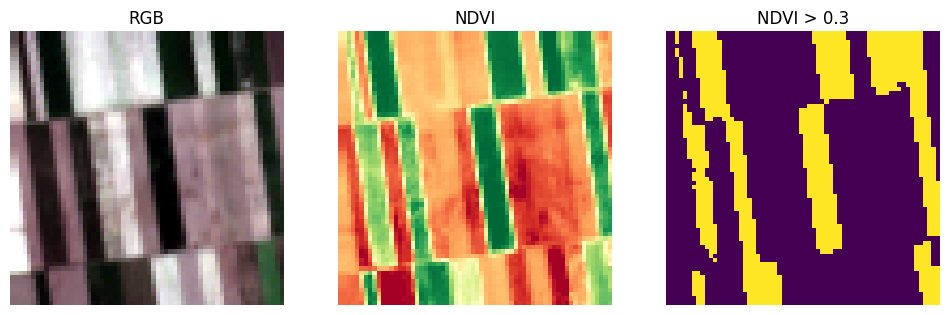

In [11]:
if samples:
    arr = read_multiband_tif(samples[0][0])
    ndvi = ndvi_from_arr(arr)
    mask = threshold_ndvi(ndvi, thr=0.3)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(np.stack([arr[3],arr[2],arr[1]], axis=-1)); plt.title("RGB"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(ndvi, cmap="RdYlGn"); plt.title("NDVI"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(mask, interpolation="nearest"); plt.title("NDVI > 0.3"); plt.axis("off")
    plt.show()


### Per-band inspection


### Cell 17 – Inspect every band
Defines `show_bands` to render each spectral band on a grid for quick qualitative review.


In [12]:
def show_bands(arr):
    import math
    cols = 4
    rows = math.ceil(arr.shape[0]/cols)
    plt.figure(figsize=(12, 3*rows))
    for i in range(arr.shape[0]):
        plt.subplot(rows, cols, i+1)
        plt.imshow(arr[i])
        plt.title(f"Band {i}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

### Cell 18 – Display per-band montage
Applies `show_bands` to the first sample to visualize all 13 bands.


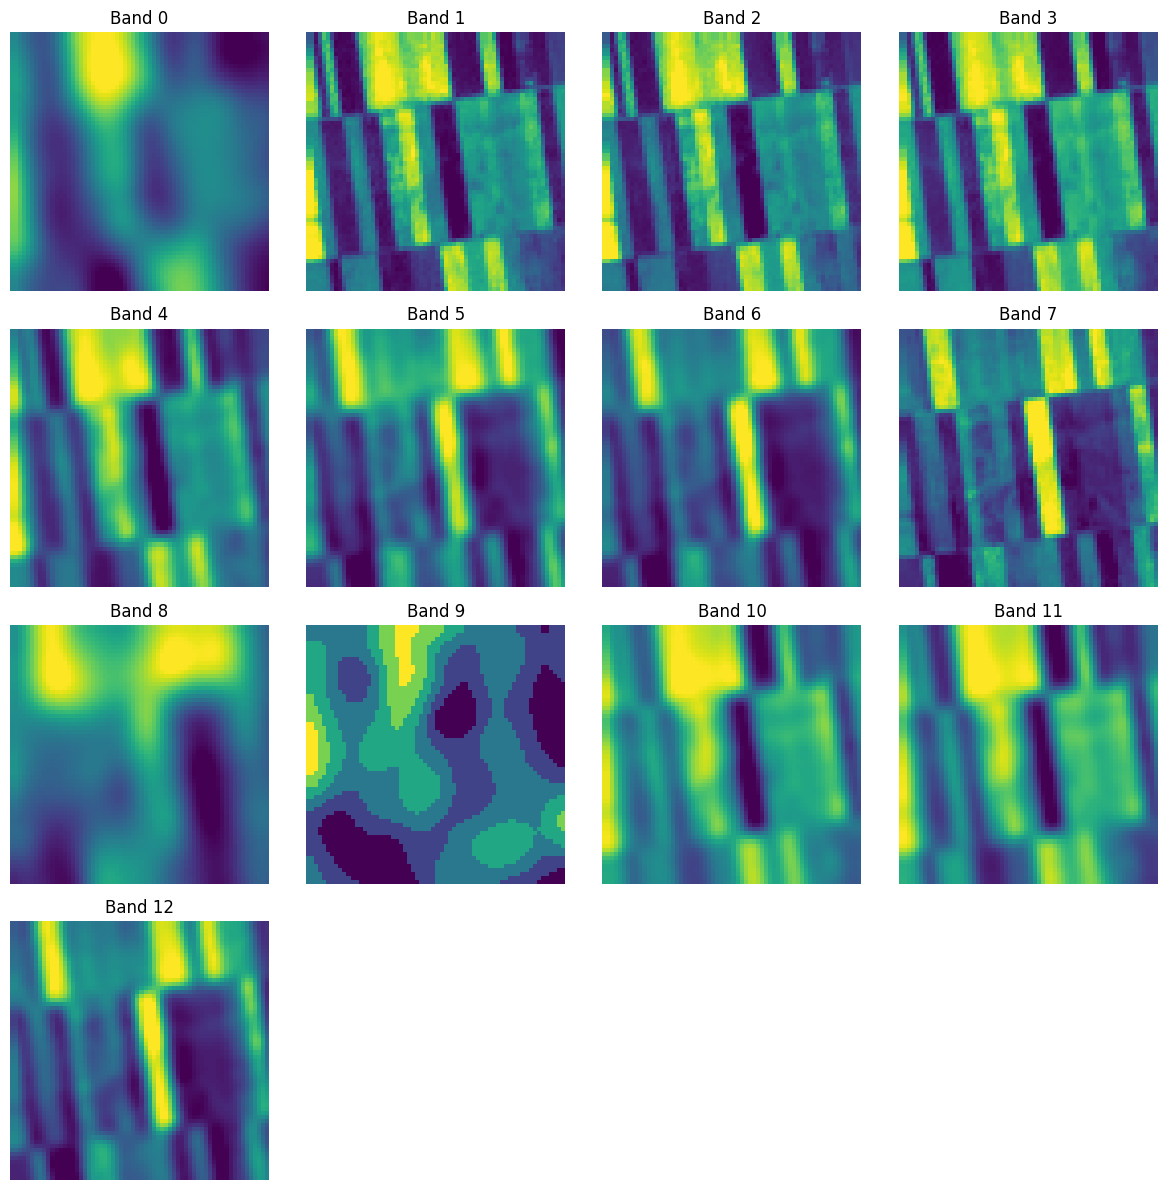

In [13]:
if samples:
    arr = read_multiband_tif(samples[0][0])
    show_bands(arr)


## 4) Feature Engineering for Conventional ML


### Cell 20 – Derive statistical features
This cell details the pipeline that converts each multiband raster into a tabular vector: per-band mean/std/percentiles capture spectral intensity, NDVI statistics encode vegetation signals, and concatenating them yields a dense descriptor per tile. It is the foundation for fitting lightweight classifiers without touching raw images.


In [14]:
def image_features(arr):
    """Return a 1D feature vector using simple, fast statistics per band + NDVI."""
    feats = []
    # per-band stats
    for i in range(arr.shape[0]):
        band = arr[i]
        p25, p50, p75 = np.percentile(band, [25,50,75])
        feats.extend([band.mean(), band.std(), p25, p50, p75])
    # NDVI stats
    ndvi = ndvi_from_arr(arr)
    p25, p50, p75 = np.percentile(ndvi, [25,50,75])
    veg_ratio = (ndvi > 0.3).mean()
    feats.extend([ndvi.mean(), ndvi.std(), p25, p50, p75, veg_ratio])
    return np.array(feats, dtype=np.float32)

### Cell 21 – Downsample spatial features
`downsampled_flat` aggressively strides the image grid so each band shrinks to about 16×16, then flattens all bands together. That keeps enough coarse spatial structure (textures, edges) to help PCA + linear models while slashing dimensionality compared to the original 64×64×13 cubes.


In [15]:
# compact spatial features via downsampling then PCA later
def downsampled_flat(arr, target=16):
    # simple spatial downsample by stride to roughly target x target per band
    C,H,W = arr.shape
    sx = max(1, H//target)
    sy = max(1, W//target)
    small = arr[:, ::sx, ::sy]
    return small.reshape(-1)  # C * h * w

### Cell 22 – Build feature matrices
We iterate over every tile, cache both feature representations, and track labels/paths. This is the compute-heavy stage that converts the EuroSAT archive into aligned numpy arrays (`X_stats`, `X_flat`, `y`) so later cells can split, train, and evaluate models without re-reading GeoTIFFs.


In [16]:
# Build dataset matrices
X_stats, y, paths = [], [], []
X_flat = []
for p, lab in samples:
    a = read_multiband_tif(p)
    X_stats.append(image_features(a))
    X_flat.append(downsampled_flat(a, target=16))
    y.append(lab); paths.append(str(p))

X_stats = np.stack(X_stats) if X_stats else np.empty((0,))
X_flat  = np.stack(X_flat)  if X_flat  else np.empty((0,))
y = np.array(y)
print("Feature shapes -> stats:", X_stats.shape, "| flat (for PCA):", X_flat.shape, "| labels:", y.shape)


Feature shapes -> stats: (27000, 71) | flat (for PCA): (27000, 3328) | labels: (27000,)


## 5) Train/Validation/Test Split


### Cell 24 – Stratified splits and dataset slicing
Creates stratified train/val/test indices and applies them to both feature sets plus label/path arrays.


In [17]:
N = len(y)
idx = np.arange(N)

# 1) Train/Test (stratified)
idx_tr, idx_te = train_test_split(
    idx, test_size=0.20, random_state=RANDOM_SEED, stratify=y
)

# 2) Train/Val (stratified) — only within the training set
y_tr = y[idx_tr]
idx_tr_sub, idx_val_sub = train_test_split(
    idx_tr, test_size=0.20, random_state=RANDOM_SEED, stratify=y_tr
)

# Now slice ALL views (stats, flat, labels, paths) with the SAME indices
Xtr_stats, Xval_stats, Xte_stats = X_stats[idx_tr_sub], X_stats[idx_val_sub], X_stats[idx_te]
Xtr_flat,  Xval_flat,  Xte_flat  = X_flat[idx_tr_sub],  X_flat[idx_val_sub],  X_flat[idx_te]
ytr,       yval,       yte       = y[idx_tr_sub],       y[idx_val_sub],       y[idx_te]

paths_tr = [paths[i] for i in idx_tr_sub]
paths_val = [paths[i] for i in idx_val_sub]
paths_te  = [paths[i] for i in idx_te]

print("Stats features -> train/val/test:", Xtr_stats.shape, Xval_stats.shape, Xte_stats.shape)
print("Flat  features -> train/val/test:", Xtr_flat.shape,  Xval_flat.shape,  Xte_flat.shape)
print("Labels ->", ytr.shape, yval.shape, yte.shape)


Stats features -> train/val/test: (17280, 71) (4320, 71) (5400, 71)
Flat  features -> train/val/test: (17280, 3328) (4320, 3328) (5400, 3328)
Labels -> (17280,) (4320,) (5400,)


## 6) Conventional ML Baselines (scikit-learn)


### Cell 26 – Validation helper
Defines `eval_pipeline` to fit a pipeline on training features, score on validation data, and report accuracy.


In [18]:
def eval_pipeline(name, pipe, Xtr, ytr, Xval, yval):
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xval)
    acc = accuracy_score(yval, pred)
    print(f"[{name}] val acc: {acc:.3f}")
    return acc, pipe

### Cell 27 – Pipelines on statistical features
Configures Logistic Regression, SVM, and Random Forest pipelines operating on the per-band statistics.


In [19]:
# Model A: Stats features -> Standardize -> Classifier
pipelines_stats = {
    "LogReg": Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, n_jobs=None, class_weight="balanced"))]),
    "SVM-RBF": Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced"))]),
    "RandomForest": Pipeline([("clf", RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, class_weight="balanced_subsample"))]),
}

### Cell 28 – Pipelines on flattened PCA features
Defines PCA-driven pipelines for Logistic Regression and SVM on the downsampled spatial features.


In [20]:
# Model B: Flattened downsampled -> Standardize -> PCA -> Classifier
pipelines_flat = {
    "PCA+LogReg": Pipeline([("scaler", StandardScaler(with_mean=True)), ("pca", PCA(n_components=128, random_state=RANDOM_SEED)), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))]),
    "PCA+SVM": Pipeline([("scaler", StandardScaler(with_mean=True)), ("pca", PCA(n_components=128, random_state=RANDOM_SEED)), ("clf", SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced"))]),
}

### Cell 29 – Train and select best pipeline
Runs every pipeline on both feature families, reports validation accuracy, and tracks the best-performing model.


In [21]:
best = (0.0, None, None)
print("=== Using Stats Features ===")
for name, pipe in pipelines_stats.items():
    acc, fitted = eval_pipeline(name, pipe, Xtr_stats, ytr, Xval_stats, yval)
    if acc > best[0]:
        best = (acc, f"stats::{name}", fitted)

print("\n=== Using Downsampled + PCA Features ===")
for name, pipe in pipelines_flat.items():
    acc, fitted = eval_pipeline(name, pipe, Xtr_flat, ytr, Xval_flat, yval)
    if acc > best[0]:
        best = (acc, f"pca::{name}", fitted)

print("\nBest model on validation:", best[1], "with acc", round(best[0],3))
best_model = best[2]


=== Using Stats Features ===
[LogReg] val acc: 0.705
[SVM-RBF] val acc: 0.811
[RandomForest] val acc: 0.740

=== Using Downsampled + PCA Features ===
[PCA+LogReg] val acc: 0.476
[PCA+SVM] val acc: 0.719

Best model on validation: stats::SVM-RBF with acc 0.811


## 7) Test Evaluation


### Cell 31 – Evaluate on held-out test split
Uses the winning model to score the test fold, prints a classification report, and renders the confusion matrix.


                      precision    recall  f1-score   support

          AnnualCrop       0.82      0.85      0.84       600
              Forest       0.87      0.89      0.88       600
HerbaceousVegetation       0.70      0.69      0.70       600
             Highway       0.69      0.67      0.68       500
          Industrial       0.90      0.85      0.88       500
             Pasture       0.79      0.77      0.78       400
       PermanentCrop       0.66      0.68      0.67       500
         Residential       0.86      0.87      0.87       600
               River       0.93      0.91      0.92       500
             SeaLake       0.89      0.91      0.90       600

            accuracy                           0.81      5400
           macro avg       0.81      0.81      0.81      5400
        weighted avg       0.81      0.81      0.81      5400



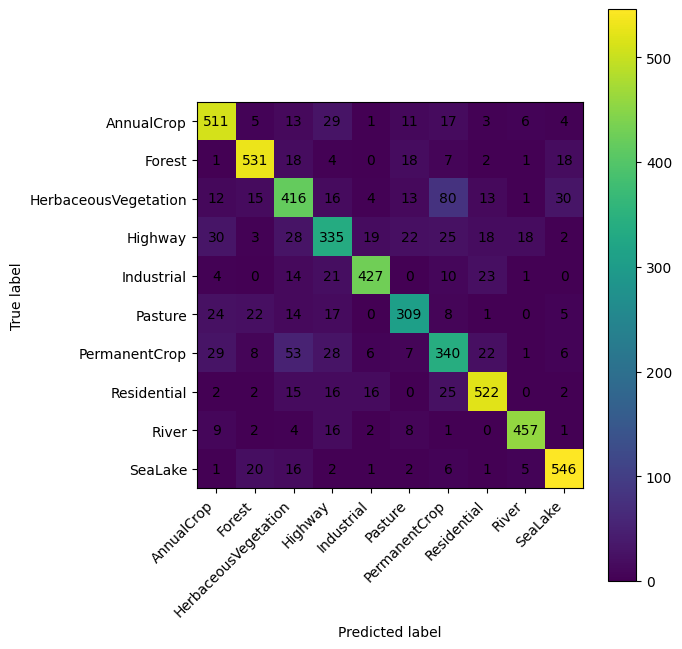

In [22]:
# Choose the right test features for the winning pipeline
if best_model is None:
    raise RuntimeError("No model trained. Check earlier cells.")

use_stats = best[1].startswith("stats::")
Xte = Xte_stats if use_stats else Xte_flat

yhat = best_model.predict(Xte)
print(classification_report(yte, yhat, target_names=CLASS_NAMES))

cm = confusion_matrix(yte, yhat)
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(len(CLASS_NAMES)), yticks=np.arange(len(CLASS_NAMES)),
       xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
       ylabel="True label", xlabel="Predicted label")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i,j], "d"), ha="center", va="center")
plt.tight_layout()
plt.show()


## 8) Notes on Distribution Shift (still relevant)

- Ensure your splits avoid **tile leakage** (images from the same large scene should not be in both train and test).
- Normalize per band using **training-set** statistics only.
- Use augmentations that simulate realistic remote-sensing variability.
- Consider domain adaptation or self-supervised pretraining if the target domain differs significantly.


### Cell 33 – Normalize Kaggle tiles
Defines `normalize_bands` so Kaggle `.npy` tiles match the same per-band scaling as the training data.


In [25]:
def normalize_bands(arr):
    """Apply the same robust per-band [0,1] scaling used in read_multiband_tif."""
    arr = arr.astype(np.float32, copy=False)
    C, H, W = arr.shape
    for i in range(C):
        band = arr[i]
        lo, hi = np.percentile(band, [2, 98])
        if hi > lo:
            band = (band - lo) / (hi - lo)
        else:
            bmin, bmax = band.min(), band.max()
            band = (band - bmin) / (bmax - bmin + 1e-6)
        arr[i] = np.clip(band, 0.0, 1.0)
    return arr


### Cell 34 – Parse tile IDs
Implements `extract_id` to recover the integer test_id from Kaggle filenames.


In [29]:
import re
def extract_id(stem):
    m = re.search(r'(\d+)$', str(stem))
    return int(m.group(1)) if m else int(''.join(ch for ch in str(stem) if ch.isdigit()))


### Cell 35 – Prepare Kaggle data in Colab
Mounts Drive, unzips the Kaggle archive, and enumerates `.npy` files ready for feature extraction.


In [26]:
# === 1) Mount Drive & unzip Kaggle data ===
from google.colab import drive
from pathlib import Path
import zipfile, glob, os, shutil

drive.mount('/content/drive', force_remount=True)

KAGGLE_ZIP  = "/content/drive/MyDrive/ML_HSG/kaggle_data.zip"  # <-- your path
KAGGLE_ROOT = Path("/content/kaggle_data")
KAGGLE_ROOT.mkdir(parents=True, exist_ok=True)

if not any(KAGGLE_ROOT.iterdir()):
    print("Extracting", KAGGLE_ZIP, "to", KAGGLE_ROOT)
    with zipfile.ZipFile(KAGGLE_ZIP, 'r') as zf:
        zf.extractall(KAGGLE_ROOT)
else:
    print("Kaggle data already extracted at", KAGGLE_ROOT)

# find .npy files (tries nested testset/testset first)
search_patterns = [
    str(KAGGLE_ROOT / "**" / "testset" / "testset" / "*.npy"),
    str(KAGGLE_ROOT / "**" / "testset" / "*.npy"),
    str(KAGGLE_ROOT / "**" / "*.npy"),
]
from pathlib import Path
npy_paths = []
for pat in search_patterns:
    hits = sorted([Path(p) for p in glob.glob(pat, recursive=True)])
    if hits:
        npy_paths = hits
        break

print(f"Found {len(npy_paths)} .npy files")
if npy_paths[:5]:
    print("Examples:", [str(p) for p in npy_paths[:5]])
assert len(npy_paths) > 0, "No .npy files found in the extracted Kaggle data."


Mounted at /content/drive
Kaggle data already extracted at /content/kaggle_data
Found 4232 .npy files
Examples: ['/content/kaggle_data/testset/testset/test_0.npy', '/content/kaggle_data/testset/testset/test_1.npy', '/content/kaggle_data/testset/testset/test_10.npy', '/content/kaggle_data/testset/testset/test_100.npy', '/content/kaggle_data/testset/testset/test_1000.npy']


### Cell 36 – Build Kaggle feature matrices
Normalizes every Kaggle tile, computes either statistical or flattened features, and stores the associated IDs.


In [30]:
# === 2) Helpers + build test features ===
import numpy as np

# Ensure (C,H,W) channel-first
def ensure_chw(arr):
    arr = np.asarray(arr)
    if arr.ndim == 2:                # single band -> (1,H,W)
        return arr[None, ...]
    if arr.ndim != 3:
        raise ValueError(f"Unsupported array ndim: {arr.ndim}")
    if arr.shape[0] in (10,11,12,13):         # already channels-first
        return arr
    if arr.shape[-1] in (10,11,12,13):        # channels-last -> channels-first
        return np.transpose(arr, (2,0,1))
    # fallback: assume channels-first
    return arr

# Pad test arrays to 13 bands (training was 13-band; many test sets have 12 bands missing B10)
def pad_to_13_bands(arr):
    """
    If input has 12 bands (common case), insert a zero band at index 9 (B10 position).
    This preserves RED (idx=3) and NIR (idx=7) for NDVI in your feature code.
    """
    arr = ensure_chw(arr)
    if arr.shape[0] == 13:
        return arr
    if arr.shape[0] == 12:
        C,H,W = arr.shape
        zero_band = np.zeros((1, H, W), dtype=arr.dtype)
        return np.concatenate([arr[:9], zero_band, arr[9:]], axis=0)
    raise ValueError(f"Expected 12 or 13 bands, got {arr.shape[0]}.")

# Sanity: make sure training artifacts exist
assert 'best_model' in globals(), "best_model not found. Run training/eval cells first."
assert 'best' in globals(), "best tuple not found. Run training/eval cells first."
assert callable(image_features), "image_features(...) not found."
assert callable(downsampled_flat), "downsampled_flat(...) not found."

use_stats = best[1].startswith("stats::")
print("Winning pipeline:", best[1], "| Using", ("stats" if use_stats else "downsampled+PCA"), "features for inference.")

# Build features for test tiles
X_stats_test, X_flat_test, test_ids = [], [], []
for p in npy_paths:
    a = np.load(p)
    a = pad_to_13_bands(a)  # <-- crucial to match training feature size
    a = normalize_bands(a)
    if use_stats:
        X_stats_test.append(image_features(a))
    else:
        X_flat_test.append(downsampled_flat(a, target=16))
    test_ids.append(extract_id(p.stem))

X_stats_test = np.stack(X_stats_test) if (use_stats and len(X_stats_test)) else None
X_flat_test  = np.stack(X_flat_test)  if ((not use_stats) and len(X_flat_test)) else None

print("Test feature shapes -> stats:",
      None if X_stats_test is None else X_stats_test.shape,
      "| flat:", None if X_flat_test is None else X_flat_test.shape)


Winning pipeline: stats::SVM-RBF | Using stats features for inference.
Test feature shapes -> stats: (4232, 71) | flat: None


### Cell 37 – Generate Kaggle submission
Applies the trained model to Kaggle features, maps predictions to class names, and writes/copies submission CSVs.


In [31]:
# === 3) Predict & write submission CSV (match sample_submission.csv) ===
import pandas as pd
from pathlib import Path

Xte_kaggle = X_stats_test if use_stats else X_flat_test
assert Xte_kaggle is not None and len(Xte_kaggle) == len(test_ids), "Feature matrix and ID list mismatch."

# Predict indices
pred_idx = best_model.predict(Xte_kaggle)

# Map to class names when available (sample expects text labels)
cls_names = CLASS_NAMES if ('CLASS_NAMES' in globals() and CLASS_NAMES) else None
pred_label = [cls_names[i] if (cls_names and i < len(cls_names)) else str(int(i)) for i in pred_idx]

# Build submission with required column names
submission = pd.DataFrame({'test_id': test_ids, 'label': pred_label})
submission = submission.sort_values('test_id').reset_index(drop=True)
out_dir = Path("/content")
sub_path = out_dir / "submission.csv"
submission.to_csv(sub_path, index=False)
print("Wrote:", sub_path)

# Copy to Drive
drive_out = Path("/content/drive/MyDrive/ML_HSG/kaggle_submissions")
drive_out.mkdir(parents=True, exist_ok=True)
shutil.copy(sub_path, drive_out / sub_path.name)
print("Copied to", drive_out)

# Debug info
try:
    print("Model n_features_in_:", getattr(best_model, "n_features_in_", "n/a"))
    print("Built features:", Xte_kaggle.shape[1])
    print("Submission shape:", submission.shape, "dtypes:", submission.dtypes.to_dict())
    print("Head:\n", submission.head())
except Exception as e:
    print("Info check skipped:", e)


Wrote: /content/submission.csv
Copied to /content/drive/MyDrive/ML_HSG/kaggle_submissions
Model n_features_in_: 71
Built features: 71
Submission shape: (4232, 2) dtypes: {'test_id': dtype('int64'), 'label': dtype('O')}
Head:
    test_id       label
0        0     SeaLake
1        1     SeaLake
2        2  AnnualCrop
3        3     SeaLake
4        4  AnnualCrop
